In [7]:
# import dsoclasses
import datetime
import attotime
import numpy as np
from dsoclasses.rinex.doris.rinex import DorisRinex
from dsoclasses.time.pyattotime import at2pt
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations

In [8]:
# set the name of the DORIS RINEX file to use
drinex = "../data/s6arx24001.001"

# set the name of the Sp3 file for the same satellite, covering the same day
dsp3 = "../data/ssas6a20.b23357.e24001.DG_.sp3.001"

In [9]:
# we will need to interpolate the satellite orbit:
sp3 = sp3c.Sp3(dsp3)
# set the id of the satellite we need; it should be the first (and only) satellite in the sp3 list
satid = sp3.sat_ids[0]
# extract its data
sp3_data = sp3.get_satellite(satid, True)
# construct an Interpolator
intrp = interpolator.OrbitInterpolator(satid, sp3_data, 1800, 12, 'CubicSpline')

In [10]:
# create a DORIS RINEX instance; this will parse the data file's header
rnx = DorisRinex(drinex)

# Select a DORIS beacon (out of the RINEX list) to extract data
diob = 'D31'

# coordinates of DIOB; can be found at IDS,
# https://ids-doris.org/network/sitelogs/station.html?code=DIONYSOS
diob_xyz=[4595212.468, 2039473.691, 3912617.891]

In [47]:
# loop through all data blocks ...
t1=None
t = []; res = [];
for block in rnx:
    for beacon, data in block:
        if beacon == diob:
            # The TAI time tag of L1 of the sequence is determined by the expression: date TAI = epoch + receiver clock offset
            t2 = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset()*1e9)
            # get satellite position for given epoch
            satx, saty, satz = intrp.at(t2)
            L2 = data['L1']['value']
            r2 = np.linalg.norm(np.array([satx, saty, satz])-np.array(diob_xyz))
            if t1 is not None and (t2 - t1).total_seconds() < 11.:
                # computed range-rate
                crr = (r2 - r1) / (float((t2-t1).total_nanoseconds()) * 1e-9)
                # observed range-rate
                orr = ((L2-L1) / (float((t2-t1).total_nanoseconds()) * 1e-9)) * (299792458./2036.25e6)
                # very loose outlier detection
                if abs(orr - crr) > 100.:
                    pass
                else:
                    t.append(at2pt(t2))
                    res.append(orr -
 crr)
                    #print("r1={:.3f} r2={:.3f}[m] t={:5.1f}[sec] Ndop={:12.2f}[cycles] {:+10.3f} - {:+10.3f} {:10.3f} {:.1f}".\
                    #  format(r1,r2,float((t2-t1).total_nanoseconds()) / 1e9,(L2-L1),orr,crr,r2-r1, orr+crr))
            r1 = r2
            t1 = t2
            L1 = L2
            

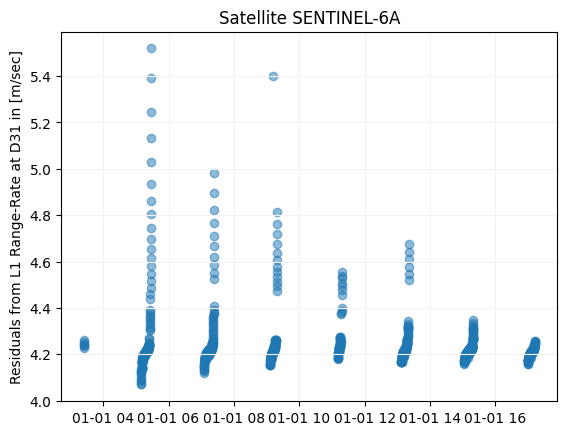

In [49]:
# import modules for plotting ...
import matplotlib.pyplot as plt
import numpy as np

# create a scatterplot of extracted L1 values w.r.t. time
plt.scatter(t, res, alpha=0.5)
plt.grid(color='0.95')
plt.ylabel("Residuals from L1 Range-Rate at {:} in [m/sec]".format(diob))
plt.title("Satellite {:}".format(rnx.sat_name))
plt.show()